In [ ]:
!mkdir pos_tagger

In [ ]:
cd pos_tagger

/content/pos_tagger


In [ ]:
!wget http://www.cnts.ua.ac.be/conll2000/chunking/train.txt.gz -O - | gunzip | cut -f1,2 -d" " > pos.train.txt

--2021-08-18 13:31:19--  http://www.cnts.ua.ac.be/conll2000/chunking/train.txt.gz
Resolving www.cnts.ua.ac.be (www.cnts.ua.ac.be)... 146.175.13.81
Connecting to www.cnts.ua.ac.be (www.cnts.ua.ac.be)|146.175.13.81|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.clips.uantwerpen.be/conll2000/chunking/train.txt.gz [following]
--2021-08-18 13:31:20--  https://www.clips.uantwerpen.be/conll2000/chunking/train.txt.gz
Resolving www.clips.uantwerpen.be (www.clips.uantwerpen.be)... 146.175.13.81
Connecting to www.clips.uantwerpen.be (www.clips.uantwerpen.be)|146.175.13.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 611540 (597K) [application/x-gzip]
Saving to: ‘STDOUT’

-                   100%[===================>] 597.21K   833KB/s    in 0.7s    

2021-08-18 13:31:21 (833 KB/s) - written to stdout [611540/611540]



In [ ]:
!wget http://www.cnts.ua.ac.be/conll2000/chunking/test.txt.gz -O - | gunzip | cut -f1,2 -d " " > pos.test.txt

--2021-08-18 13:31:21--  http://www.cnts.ua.ac.be/conll2000/chunking/test.txt.gz
Resolving www.cnts.ua.ac.be (www.cnts.ua.ac.be)... 146.175.13.81
Connecting to www.cnts.ua.ac.be (www.cnts.ua.ac.be)|146.175.13.81|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.clips.uantwerpen.be/conll2000/chunking/test.txt.gz [following]
--2021-08-18 13:31:22--  https://www.clips.uantwerpen.be/conll2000/chunking/test.txt.gz
Resolving www.clips.uantwerpen.be (www.clips.uantwerpen.be)... 146.175.13.81
Connecting to www.clips.uantwerpen.be (www.clips.uantwerpen.be)|146.175.13.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139551 (136K) [application/x-gzip]
Saving to: ‘STDOUT’

-                   100%[===================>] 136.28K   319KB/s    in 0.4s    

2021-08-18 13:31:23 (319 KB/s) - written to stdout [139551/139551]



In [ ]:
!pip install sklearn-crfsuite

     |████████████████████████████████| 743 kB 8.1 MB/s 


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import os
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

from nltk.corpus import stopwords
import string
import re
import spacy

from collections import Counter

In [ ]:
np.random.seed(20)

In [ ]:
remove_tags = ['.',',','(',')',':','``',"''",'#','$']

In [ ]:
train_file = "pos.train.txt"
test_file = "pos.test.txt"

def create_dataset(filename):
    data = []
    label = []
    with open(filename, 'r') as f:
        x = []
        y = []
        for line in f:
            s = line.split()
            if s == []:
                data.append(" ".join(x))
                label.append(" ".join(y))
                x = []
                y = []
                continue
            x.append(s[0])
            if s[1] in remove_tags:
                y.append("PUN")
            else:
                y.append(s[1])
    return data, label

X_train, y_train_tags = create_dataset(train_file)
X_test, y_test_tags = create_dataset(test_file)

In [ ]:
POS_tags = {}
for line in y_train_tags:
    s = line.split()
    for elem in s:
        if elem not in POS_tags:
            POS_tags[elem] = 1
        else:
            POS_tags[elem] += 1
print(len(POS_tags))
print(POS_tags)

36
{'NN': 30147, 'IN': 22764, 'DT': 18335, 'VBZ': 4648, 'RB': 6607, 'VBN': 4763, 'TO': 5081, 'VB': 6017, 'JJ': 13085, 'NNS': 13619, 'NNP': 19884, 'PUN': 26009, 'CC': 5372, 'POS': 1769, 'VBP': 2868, 'VBG': 3272, 'PRP$': 1881, 'CD': 8315, 'VBD': 6745, 'EX': 206, 'MD': 2167, 'NNPS': 420, 'PRP': 3820, 'JJS': 374, 'WP': 529, 'RBR': 321, 'JJR': 853, 'WDT': 955, 'WRB': 478, 'RBS': 191, 'PDT': 55, 'RP': 83, 'FW': 38, 'WP$': 35, 'SYM': 6, 'UH': 15}


Mean = 23.66678845451224
Max = 78
Min = 1


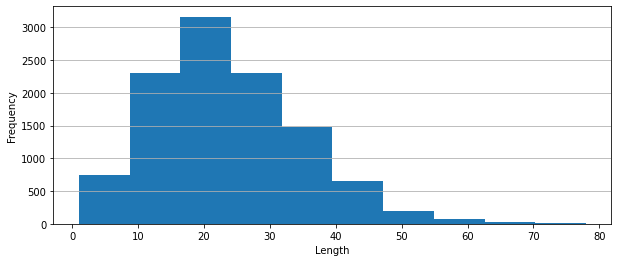

In [ ]:
length = []
for row in X_train:
  length.append(len(row.split()))
for row in X_test:
  length.append(len(row.split()))

mean = sum(length)/len(length)
print(f'''Mean = {mean}
Max = {max(length)}
Min = {min(length)}''')

plt.figure(figsize=(10, 4))
plt.hist(length)
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.grid(axis='y')
plt.show()

In [ ]:
def convert_to_lower(text):
    # return the reviews after convering then to lowercase
    for i in range(len(text)):
        text[i] = text[i].lower()
    return text

In [ ]:
def perform_tokenization(text):
    # return the reviews after performing tokenization
    tokanized_text = []
    for i in range(len(text)):
        s = text[i].split()
        tokanized_text.append(s)
    return tokanized_text 

In [ ]:
def features(sentence, index):
    """ sentence: [w1, w2, ...], index: the index of the word """
    return {
        'word': sentence[index],
        'is_first': index == 0,
        'is_last': index == len(sentence) - 1,
        'is_capitalized': sentence[index][0].upper() == sentence[index][0],
        'is_all_caps': sentence[index].upper() == sentence[index],
        'is_all_lower': sentence[index].lower() == sentence[index],
        'prefix-1': sentence[index][0],
        'prefix-2': sentence[index][:2],
        'prefix-3': sentence[index][:3],
        'suffix-1': sentence[index][-1],
        'suffix-2': sentence[index][-2:],
        'suffix-3': sentence[index][-3:],
        'prev_word': '' if index == 0 else sentence[index - 1],
        'next_word': '' if index == len(sentence) - 1 else sentence[index + 1],
        'has_hyphen': '-' in sentence[index],
        'is_numeric': sentence[index].isdigit(),
        'capitals_inside': sentence[index][1:].lower() != sentence[index][1:]
    }

In [ ]:
def preprocess_data(data, labels=None):
    # data = convert_to_lower(data)
    data = perform_tokenization(data)
    data = [[features(sent, i) for i, _ in enumerate(sent)] for sent in data]
    if labels:
        labels = [label.split() for label in labels]
    return data, labels

In [ ]:
X_train, y_train = preprocess_data(X_train, y_train_tags)
X_test, y_test = preprocess_data(X_test, y_test_tags)

In [ ]:
print(len(X_train[0]))
print(len(y_train[0]))
print(X_train[0])
print(y_train[0])

37
37
[{'word': 'Confidence', 'is_first': True, 'is_last': False, 'is_capitalized': True, 'is_all_caps': False, 'is_all_lower': False, 'prefix-1': 'C', 'prefix-2': 'Co', 'prefix-3': 'Con', 'suffix-1': 'e', 'suffix-2': 'ce', 'suffix-3': 'nce', 'prev_word': '', 'next_word': 'in', 'has_hyphen': False, 'is_numeric': False, 'capitals_inside': False}, {'word': 'in', 'is_first': False, 'is_last': False, 'is_capitalized': False, 'is_all_caps': False, 'is_all_lower': True, 'prefix-1': 'i', 'prefix-2': 'in', 'prefix-3': 'in', 'suffix-1': 'n', 'suffix-2': 'in', 'suffix-3': 'in', 'prev_word': 'Confidence', 'next_word': 'the', 'has_hyphen': False, 'is_numeric': False, 'capitals_inside': False}, {'word': 'the', 'is_first': False, 'is_last': False, 'is_capitalized': False, 'is_all_caps': False, 'is_all_lower': True, 'prefix-1': 't', 'prefix-2': 'th', 'prefix-3': 'the', 'suffix-1': 'e', 'suffix-2': 'he', 'suffix-3': 'the', 'prev_word': 'in', 'next_word': 'pound', 'has_hyphen': False, 'is_numeric': Fal

In [ ]:
from sklearn_crfsuite import CRF
 
model = CRF()
model.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm=None, all_possible_states=None, all_possible_transitions=None,
    averaging=None, c=None, c1=None, c2=None, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=None,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [ ]:
def pos_tag(sentence):
    sentence_features , _ = preprocess_data([sentence])
    return model.predict(sentence_features)[0]

In [ ]:
from sklearn_crfsuite import metrics
 
y_pred = model.predict(X_test)
print(metrics.flat_accuracy_score(y_test, y_pred))

0.9731093146463474


In [ ]:
s = "My name is Shyam and I study at EPFL university in Switzerland ."
pos_tag(s)

['PRP$',
 'NN',
 'VBZ',
 'NNP',
 'CC',
 'PRP',
 'VBP',
 'IN',
 'NNP',
 'NN',
 'IN',
 'NNP',
 'PUN']